<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Импортируем-необходимые-модули" data-toc-modified-id="Импортируем-необходимые-модули-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импортируем необходимые модули</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Изучение данных</a></span></li></ul></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Необходимо защитить данные клиентов страховой компании. Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. 

## Загрузка данных

### Импортируем необходимые модули

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import display

pd.set_option('display.max_columns', 50)
pd.set_option('display.precision', 3)


In [2]:
#константы 
STATE = np.random.RandomState(13)

### Загрузка данных

In [3]:
df = pd.read_csv('/datasets/insurance.csv')
display(df.head(5))

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Датасет содержит 5000 объектов, 4 колонки (признаков):  
- Пол — пол клиента,
- Возраст — возраст клиента,
- Зарплата — размер заработной платы в месяц,
- Члены семьи — количество членов семьи клиента,  

и целевой признак:  
- Страховые выплаты — количество страховых выплат клиенту за последние 5 лет.  

Пустых значений нет, наименование столбцов не соотвествуют стандартам snake_case.  
В датафрейме 1 категориальный признак - 'Пол', остальные признаки непрерывные.

Рассмотрим распределение данных в датасете с учетом целевого признака.

### Изучение данных

Для начала приведем название признаков в соотвествии со стандартами snake_case

In [5]:
df.columns = ['gender', 'age', 'salary', 'relatives', 'insurance_payments']
display(df.head(1))

,gender,age,salary,relatives,insurance_payments
0,1,41.0,49600.0,1,0


In [6]:
#уникальные значения в признаках
display(df.nunique().to_frame(name='unique').T)                                               

,gender,age,salary,relatives,insurance_payments
unique,2,46,524,7,6


`gender` - категориальный признак,  
Остальные признаки не прерывные, но в `relatives`, и `insurance_payments` маленькое количество уникальных значений, посмотрим как распределены значения в целевом признаки.

In [7]:
print('Распределение insurance_payments:')
display(df['insurance_payments'].value_counts().to_frame().T)
print()
print('Распределение insurance_payments в долях:')
display(df['insurance_payments'].value_counts(normalize = True).to_frame().T)

Распределение insurance_payments:


,0,1,2,3,4,5
insurance_payments,4436,423,115,18,7,1



Распределение insurance_payments в долях:


,0,1,2,3,4,5
insurance_payments,0.887,0.085,0.023,0.004,0.001,2.000e-04


Можем наблюдать высокую долю объектов с 0 выплатой - 89%, и уменьшением доли с увеличением количества выплат. Это нормальная ситуация которая, т.к. страховые случаю возникают редко, что обеспечивает рентабельность страхового бизнеса.

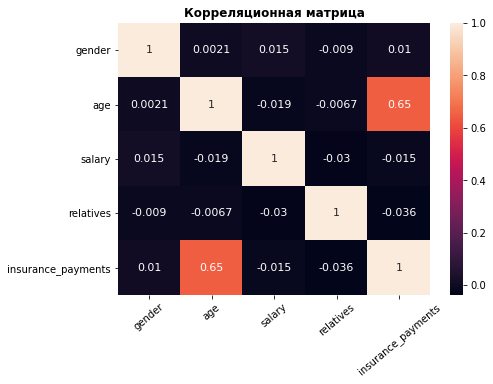

,count,mean,std,min,25%,50%,75%,max
gender,5000.0,0.499,0.500,0.0,0.0,0.0,1.0,1.0
age,5000.0,30.953,8.441,18.0,24.0,30.0,37.0,65.0
salary,5000.0,39916.360,9900.084,5300.0,33300.0,40200.0,46600.0,79000.0
relatives,5000.0,1.194,1.091,0.0,0.0,1.0,2.0,6.0
insurance_payments,5000.0,0.148,0.463,0.0,0.0,0.0,0.0,5.0


In [8]:
#проверим кореляцию признаков между собой
plt.figure(figsize = (7,5))
g = sns.heatmap(df.corr(), annot=True, annot_kws={'size' : 11})
g.set_yticklabels(df.corr().columns, rotation = 0)
g.set_xticklabels(df.corr().columns, rotation = 40)
plt.title(f'Корреляционная матрица', fontweight="bold")
plt.show()
display(df.describe().T)

Основные признаки имеют низкую корреляцию между собой.  
Отметим достаточно высокую кореляцию между целевым признаком и возрастом - `0,65`.

In [9]:
display(f'Количество дубликатов - {df.duplicated().sum()}')
print('Доля дубликатов в df -', round(df.duplicated().sum() / df.shape[0], 2))

'Количество дубликатов - 153'

Доля дубликатов в df - 0.03


В данных есть `153` дубликатов, всего `3%` от общей выборки, но так как подобные данные в признаках могут совпадать, а возможности уточнить уникальность клиентов по индексу нет, примем данный факт, и не будем удалять дубли, т.к. их наличие или отсутвие не будут оказывать существенное влияния.

## Умножение матриц

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Проверим изменится ли качество линейное регрессии при умножении признаков на обратную матрицу. 

Прежде всего подготовим основные и целевой признаки для обучения моделей

In [29]:
# выделим в данных признаки и целевой признак
features = df.drop(['insurance_payments'], axis=1)
target = df['insurance_payments']
 
# зададим матрицу признаков X
X = np.array(features)
 
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
 
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0
    
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print(r2_score(target, predictions))
 
#Создадим матрицу P, состоящую из случайных чисел и имеющюю такой размер, 
#чтобы при умножении на X получалась матрица того же размера, что и X. 
#Как задать размер матрицы P: это должна быть квадратная матрица, а ширина должна быть равна количеству признаков - 4. 

 


0.42494550286668


In [30]:
np.random.seed(100) # фиксируем случайность
 
P =  np.random.normal(3, 2.5, size=(4, 4))
 
#Умножим матрицы X и Р и получим новую матрицу A, проверяем размер
A = X @ P
A.shape


(5000, 4)

In [31]:
model.fit(A, target)
predictions = model.predict(A)
print(r2_score(target, predictions))

0.42494550286205446


In [10]:
features, target = df.drop('insurance_payments', axis=1).values, df['insurance_payments'].values

Создадим класс для проведения предварительной оценки модели Линейной регрессии, которая будет предсказывать по вышеупомянутой формуле обучения. 

In [11]:
class CustomLinearRegression:
    
    def fit(self, x_train, y_train):
        X = np.insert(x_train, 0, 1, axis=1)
        w = np.linalg.inv((X.T @ X)).dot(X.T).dot(y_train)               
        self.w = w[1:]
        self.w0 = w[0]        
      
        
    def predict(self, y_new):
        return y_new.dot(self.w) + self.w0

In [12]:
#функция обучения, предсказания и оценки модели
def fit_pred_score(regressor, x_train, y_train, score='R2'):
    model = regressor()
    model.fit(x_train, y_train)
    predictions = model.predict(x_train)
    
    if score == 'R2':
        r2 = r2_score(y_train, predictions).round(4)
        display(f'Оценка R2- {r2}')
        return r2
    else:
        mse = mean_squared_error(y_train, predictions).round(4)
        display(f'Оценка MSE - {mse}')
        return mse

In [13]:
mse_norm = fit_pred_score(CustomLinearRegression, features, target, 'mse')

'Оценка MSE - 0.1233'

Создадим `P` матрицу из случайных чисел, используя рандомные значения.  

In [14]:
P = np.random.normal(0, 1, (features.shape[1], features.shape[1]))
print('Матрица случайных чисел:\n', P)

Матрица случайных чисел:
 [[ 0.30839636  0.07693585 -0.20756042  1.53977973]
 [-0.58578439  0.09423814 -1.69754038 -0.4275713 ]
 [ 1.15628168 -0.38524551 -0.37290455  0.12078786]
 [-1.30963165 -0.78336666 -0.43709233 -1.43804   ]]


Проверим, что матрица `P`, является обратимой матрицой. Если она вляется таковой, то произмедение матрицы и ее же инверсионную копию даст еденичную матрицу: 
- $E$ — единичная матрица 

$$
E = P * P^{-1}
$$


In [15]:
print('Проверим обратимость матрицы:\n', np.around(P @ np.linalg.inv(P)))

Проверим обратимость матрицы:
 [[ 1.  0. -0. -0.]
 [ 0.  1. -0. -0.]
 [ 0. -0.  1.  0.]
 [-0.  0.  0.  1.]]


`P` - является обратимой матрицой, для далнейшей проверки умножим матрицу всех признаков на обратимую матрицу `P`

In [16]:
X_encode = features.dot(P)
print(X_encode[:5])

[[ 57326.55290575 -19105.01980116 -18566.30938332   5973.6491272 ]
 [ 43910.44810568 -14635.77766816 -14248.89676935   4568.83232547]
 [ 24264.92752121  -8087.42273538  -7880.22417655   2524.14547309]
 [ 48202.0252979  -16064.32536326 -15586.64217937   5024.99864674]
 [ 30162.85826721 -10052.19212203  -9780.5473908    3142.1309055 ]]


In [17]:
mse_encode = fit_pred_score(CustomLinearRegression, X_encode, target, 'mse')

'Оценка MSE - 0.1233'

Сравним полученные оценки:

In [18]:
print('Оценки mse на исходных и преобразованных данных -', mse_norm == mse_encode)

Оценки mse на исходных и преобразованных данных - True


**Ответ:**  
При умножении признаков на обратимую матрицу, качество линейной регрессии не изменяется.

**Обоснование:**  
При умножении текущих признаков `Х` на рандомную случайную матрицу `P` получаем новую матрицу `X_encode`, в связи с этим формула предсказаня:

$$
a = X * Xencode * w
$$

Формула получение весов для расчета, примет вид:

$$
w_i = ((X * Xencode)^T X * Xencode)^{-1} (X * Xencode)^T * y
$$

Сократим запись учитывая $Xencode^T * (Xencode^T)^{-1}$ это еденичная матрица, умножая на которую мы получаем ту же матрицу:  

$$
w_i = (Xencode^{-1} (X^T * X))^{-1} X^T * y
$$

В результате мы можем наблюдать, что новые веса можно выразить через старые веса

$$
w_i = Xencode^{-1} * w
$$

При такой взаимосвязи параметров задачи линейной регрессии с исходной матрицой и задачи линейной регрессии с преобразованной матрицей (умноженной на обратимую  матрицу), веса изменяются под новые значения и поэтому не повлияют на качество линейное регрессии 

**Обоснование:**

Используемые свойства:
$$
(AB)^T=B^T A^T
$$
$$
(AB)^{-1} = B^{-1} A^{-1}
$$
$$
A A^{-1} = A^{-1} A = E
$$
$$
AE = EA = A
$$


\
Требуется доказать, что предсказания не изменятся, имеем  $a =  Xw$,   $a' = X'w'$
\
\
**Доказательство**:
$$
w = (X^T X)^{-1} X^T y
$$
\
$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$
$$
w' = (P^T (X^T X) P)^{-1} (XP)^T y
$$
$$
w' = (P^T (X^T X) P)^{-1} P^T X^T y
$$
$$
w' = P^{-1}(X^T X)^{-1} ((P^T)^{-1} P^T) X^Ty
$$

Так как матрица $P$ по обратимая, произведение $(P^T)^{-1}P^T$ равно единичной матрице, а матрица умноженная на еденичную матрицу равна сама себе, можно сократить:
$$
w' = P^{-1}(X^T X)^{-1} X^Ty
$$

Часть записи $(X^T X)^{-1} X^Ty$ из полученной $w' = P^{-1}(X^T X)^{-1} X^Ty$ соответствует $w = (X^T X)^{-1} X^Ty$, отсюда:
$$
w' = P^{-1}w
$$

Применим значение весов w' к формуле предсказания $a = Xw$ и получим:

$$
a' = X'w'
$$
$$
a' = XPP^{-1}w
$$

По условиям обратимости выражение $P*P^{-1}$ равно единичной матрице, и следовательно, можно записать как:
$$
a' = Xw = a
$$




Вычислим значение предсказания:
 
$a' = X P w'$
 
$w' = ((X P)^T (X P))^{-1} (X P)^T y$
 
$a' = X P ((X P)^T (X P))^{-1} (X P)^T y$
 
Воспользуемся свойством обратной матрицы $(A B)^{-1} = B^{-1} A^{-1}$
 
$a' = X P ((X P)^T (X P))^{-1} (X P)^T y = X P (X P)^{-1} ((X P)^T)^{-1} (X P)^T y = X P P^{-1} X^{-1} ((X P)^T)^{-1} (X P)^T y$
 
Воспользуемся свойством транспонированной матрицы $(A B)^T = B^T A^T$
 
$a' = X E X^{-1} ((X P)^T)^{-1} (X P)^T y = X X^{-1} (P^T X^T)^{-1} P^T X^T y = X X^{-1} (X^T)^{-1} (P^T)^{-1} P^T X^T y = X X^{-1} (X^T)^{-1} E X^T y = X (X^T X)^{-1} X^T y$
 
Из этого следует вывод, что значение предсказания `a` не меняется.


-------------------------------------------------------------------------
$$
(AB)^{-1} = B^{-1} A^{-1}
$$
 
только когда у нас A и B квадратные, Может когда то в линейную алгебру введут "мнимые матрицы", по подобию "мнимых чисел" )) Но пока не ввели, поэтому перепрыгивать через этот момент не можем, это как на ноль делить
 
И маленькая подсказка, найди тут:
 
$$
((XP)^T XP)^{-1}
$$
 
три квадратные матрицы. Зачем, спросишь ты, нам 3 матрицы под знаком обратной матрицы (-1), а ты найди под -1 три квадратные матрицы, чтобы можно будет раскрыть скобку, по правилу:  
 
$$
(ABС)^{-1} = ((AB)С)^{-1} = ((AB)С)^{-1} = С^{-1}(AB)^{-1} = С^{-1}B^{-1}A^{-1}
$$

## Алгоритм преобразования

**Алгоритм преобразования и проверки качества**
 - маштабирование признаков методом `StandardScaler` 
 - в качестве метрики оценки качества возьмем коэффициент детерминации `R2`
 - обучение моделей на исходных данных
 - получение метрик качества модели линейной регрессии на исходных данных
 - создание матрицы со случайными величинами - $P$
 - проверка ее на обратимость путем возможности инвертировать ее через функцию `np.linalg.inv`
 - преобразование текущих признаков путем умножения их на случайную матрицу $X * P$
 - обучение моделей на преобразованных данных
 - получение метрик качества модели линейной регрессии на преобразованных данных
 - сравнения полученных метрик и при их равенстве завершаем алгоритм
 
Создадим класс, которые будет преобразовывать данные с помощью кодирования и раскодирования, используя вышеупомятого взаимосвязи параметров и способности весов, меньяться под новые значения. В целях возможности раскодирования данных, при кодировании будет возвращаться матрица-ключ, при момощи которого мы сможем получить обратные данные по формуле:

$$
X = Xencode * P^{-1}
$$

In [19]:
class transform_matrix:
    
    def encode(self, X):
        P = np.random.normal(0, 1, (X.shape[1], X.shape[1]))
        try:
            P_inv = np.linalg.inv(P)
            X_encode = X.dot(P)
            return X_encode, P
                   
        except np.linalg.LinAlgError as err_linalg:
            print('Ошбика инверсии матрицы:', err_linalg)
            return None, None
            
            
    def decode(self, X_encode, matrix):
        X = X_encode.dot(np.linalg.inv(matrix))
        df = pd.DataFrame(np.around(X))
        df.columns = ['gender', 'age', 'salary', 'family']
        return df

Выше обосновывая взаимосвязь параметров линейной регресии мы обосновали то, что качество линейной регресии не поменяется, и производили сравнение оценки исходной выборки и преобразованной выборки, где получили одинаковые оценки. Ниже сравним основные признаки из `X_train` и обратно преобразованные из `X_encode` в датафрейм.

In [20]:
#для сравния посмотрим на признаки
df_feature = pd.DataFrame(np.around(features))
df_feature.columns = ['gender', 'age', 'salary', 'family']
display(df_feature.head())

,gender,age,salary,family
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


In [21]:
#закодируем и получим матрицы
trans_matrix = transform_matrix()
X_encode, P = trans_matrix.encode(features)

In [22]:
df_decode = trans_matrix.decode(X_encode, P)
display(df_decode.head())

,gender,age,salary,family
0,1.0,41.0,49600.0,1.0
1,-0.0,46.0,38000.0,1.0
2,-0.0,29.0,21000.0,-0.0
3,-0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,-0.0


In [23]:
print('Датафремйы равны -', df_feature.equals(df_decode))

Датафремйы равны - True


**Обоснование:**

В вышеприведенный пример преобразования данных и обратного преобразования с использованием матрицы-ключа (инверсии случайной матрицы `P`), явно показывает, что предсказания для матрицы признаков, умноженных на обратимую матрицу `P` равны предсказаниям преобразованной матрицы, следовательно качество линейной регрессии при подобном преобразовании не изменится. 

## Проверка алгоритма

Проведем маштабирование столбцов `age`,`salary`, `family`.

In [24]:
scaler = StandardScaler()
features[:, 1:] = scaler.fit_transform(features[:, 1:])
print(features[:5])

[[ 1.          1.19043179  0.97823503 -0.17795659]
 [ 0.          1.78285146 -0.19358944 -0.17795659]
 [ 0.         -0.23137543 -1.91091841 -1.09431388]
 [ 0.         -1.1792469   0.18018215  0.7384007 ]
 [ 1.         -0.34985936 -1.39571972 -1.09431388]]


Обучим модель линеной регрессии, на исходных маштабированных данных, и оценим спомощью `R2`. 

In [25]:
r2_norm = fit_pred_score(LinearRegression, features, target)

'Оценка R2- 0.4249'

Создадим матрицу со случайными величинами `P`, проверим ее на обратимость путем возможности инвертировать ее через функцию `np.linalg.inv`, преобразeем текущие признаки путем умножения их на случайную матрицу $X ∗ P$

In [26]:
X_encode, P = trans_matrix.encode(features)

Обучим модель линеной регрессии, на преобразованных и маштабированных данных, и оценим спомощью `R2`. 

In [27]:
r2_encode = fit_pred_score(LinearRegression, X_encode, target)

'Оценка R2- 0.4249'

In [28]:
print('Равенство значений исходных и преобразованных данных -', r2_norm == r2_encode)

Равенство значений исходных и преобразованных данных - True


Оценки `R2` по исходным и преобразованным данным равны.

## Вывод

Данное исследование было реализовано, с целью разработки и тестирования метода защиты данных о клиентах, путем преобразования данных таким образом, чтоб это не влияло на качество работы модели. 

Входные данные - обработанные данные, которые содержат в себе `5000` объектов, содержащие в себе данные о клиентах.

**Цель проекта**
- Проверить качество данных
- Проверить влияние на качество использования способа преобразования путем умножения на обратимую матрицу
- Предложить и построить алгоритм с помощью которого будет производиться преобразования объектов и проверка качества работы модели на исходных и преобразованных данных.


**В ходе исследования:**
- Было проверенны данные, которые в целом были нормально предобработаны, за исключением наличия дубликатов, по которым не было возможности уточнить дополнительную информацию.
- Было проверенно и обосновано то, что при умножении признаковна обратимую матрицу, качество линейной регресии не меняется, за счет свойств обратимых матриц, которые при умножении на саму себя преобразовывается в еденичную матрицу. 
- Написали новые методы и классы с помощью которых смогли предсказывать, оценивать, преобразовывать с помощью кодирования и раскодирования данных
- С помощью вышеописанных методов и классов смогли закодировать данные из датафрема и раскодировать обратно в датафрейм с аналогичными данными.
- Был разработан алгоритм преобразования и проверки качества модели линейной регрессии.
- При проверке, мы в очередной раз убедились, что модель линейной регрессии может предсказывать на преобразованных данных точно так же как и на исходных данных.

**В итоге:**   
Мы определили, что при использовании модели линейной регрессии , в том числе из стандартной библиотеки `sklearn`, мы можем использовать возможности кодирования данных клиентов, без рисков снижения качества модели, а так же возможность получения исходных данных из закодированных при необходимости. 